#---------------Forecasting---------------#

In [2]:
#Load Demand Data
import pandas as pd
import matplotlib.pyplot as plt

forecast = pd.read_csv("../data/cleaned/demand_forecast.csv")
forecast

,product_id,month,forecast_qty,actual_demand
0,P001,2024-01,5537,4051
1,P001,2024-02,7360,8812
2,P001,2024-03,7904,8494
3,P002,2024-01,8732,9398
4,P002,2024-02,5993,5302
5,P002,2024-03,4201,2537
6,P003,2024-01,9170,7390
7,P003,2024-02,6637,5198
8,P003,2024-03,6685,7101
9,P004,2024-01,8767,7828


#Converting Month Column for Ploting

In [3]:
forecast["month"] = forecast["month"].astype(str)
forecast

,product_id,month,forecast_qty,actual_demand
0,P001,2024-01,5537,4051
1,P001,2024-02,7360,8812
2,P001,2024-03,7904,8494
3,P002,2024-01,8732,9398
4,P002,2024-02,5993,5302
5,P002,2024-03,4201,2537
6,P003,2024-01,9170,7390
7,P003,2024-02,6637,5198
8,P003,2024-03,6685,7101
9,P004,2024-01,8767,7828


#Visualizing Actual Demand (Before Forecasting)

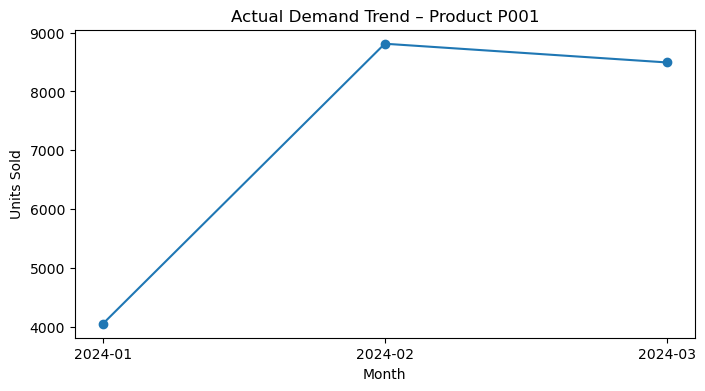

In [4]:
#For example considering Product-P001
p001 = forecast[forecast["product_id"] == "P001"]

#Visualozing Demand Trend
plt.figure(figsize=(8,4))
plt.plot(p001["month"], p001["actual_demand"], marker="o")
plt.title("Actual Demand Trend – Product P001")
plt.xlabel("Month")
plt.ylabel("Units Sold")
plt.show()

Types of Forecasting:
Method 1: Moving Average
    -> Smooths past demand
    -> Very common in industry
Method 2: Simple Linear Regression
    -> Detects trend (increasing / decreasing demand)

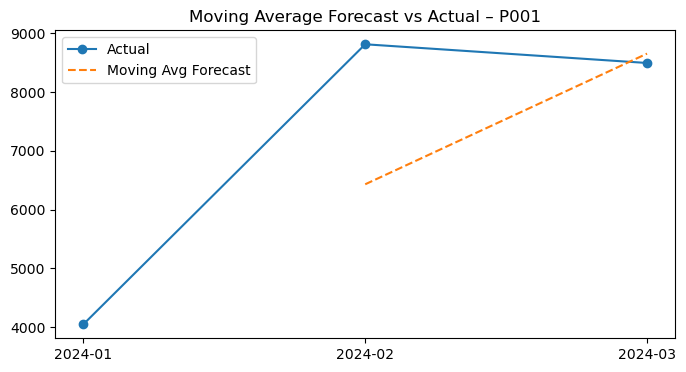

In [12]:
#Method 1: Moving Average Forecast

# Create product-specific dataframe safely
p001 = forecast[forecast["product_id"] == "P001"].copy()

# Moving average forecast (2-period)
p001["moving_avg_forecast"] = (
    p001["actual_demand"].rolling(window=2).mean()
)

#Visualize Moving Average Forecast
plt.figure(figsize=(8,4))
plt.plot(p001["month"], p001["actual_demand"], label="Actual", marker="o")
plt.plot(p001["month"], p001["moving_avg_forecast"], label="Moving Avg Forecast", linestyle="--")
plt.title("Moving Average Forecast vs Actual – P001")
plt.legend()
plt.show()

#Evaluate Forecast Accuracy

In [20]:
#Forecast Error
p001["forecast_error"] = (
    p001["actual_demand"] - p001["moving_avg_forecast"]
)

#Mean Absolute Error(MAE)
mae = p001["forecast_error"].abs().mean()
print("{**Lower MAE = better forecast","\n",
      "**High MAE = unreliable forecasting}")
MAE = float(mae)
print("Obtained MAE value = ",MAE)
print(f"On average, the forecast is off by ~{MAE} units per period")

{**Lower MAE = better forecast 
 **High MAE = unreliable forecasting}
Obtained MAE value =  1269.75
On average, the forecast is off by ~1269.75 units per period


#Method 2: Simple Linear Regression Forecast

In [22]:
#Prepare Data
from sklearn.linear_model import LinearRegression
import numpy as np
X = np.arange(len(p001)).reshape(-1, 1)  # time index
y = p001["actual_demand"].values

In [24]:
#Train Model
model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [26]:
#Predict Demand
p001["linear_forecast"] = model.predict(X)

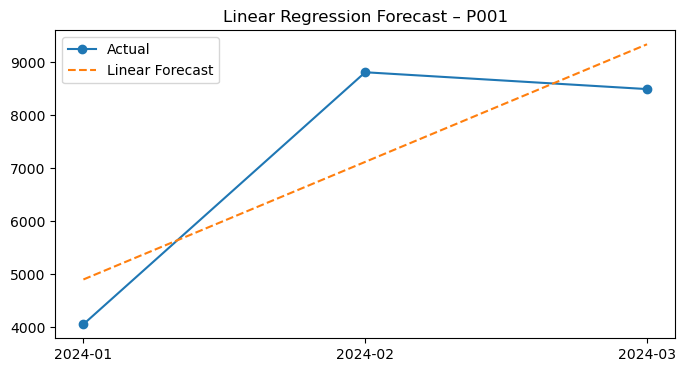

In [27]:
#Visualize Regression Forecast
plt.figure(figsize=(8,4))
plt.plot(p001["month"], p001["actual_demand"], label="Actual", marker="o")
plt.plot(p001["month"], p001["linear_forecast"], label="Linear Forecast", linestyle="--")
plt.title("Linear Regression Forecast – P001")
plt.legend()
plt.show()

📌Insight: Linear regression captures demand trend but may overestimate during volatile periods.

#Forecast vs Actual

In [31]:
comparison = p001[[
    "month",
    "actual_demand",
    "forecast_qty",
    "moving_avg_forecast"
]]
comparison

,month,actual_demand,forecast_qty,moving_avg_forecast
0,2024-01,4051,5537,NaN
1,2024-02,8812,7360,6431.5
2,2024-03,8494,7904,8653.0


#---------------Inventory Optimization---------------#
(tested & working for all products)

In [32]:
#Load Required Data
import pandas as pd
orders = pd.read_csv("../data/cleaned/orders.csv")
forecast = pd.read_csv("../data/cleaned/demand_forecast.csv")

In [101]:
#Calculate Daily Demand (Approximation)
P001_demand = forecast[forecast["product_id"]=="P001"]

avg_daily_demand = P001_demand["actual_demand"].mean()/30
max_daily_demand = P001_demand["actual_demand"].max()/30

add = int(avg_daily_demand)
mdd = int(max_daily_demand)

print(f"The average & max daily demand are: {add},{mdd}")

The average & max daily demand are: 237,293


In [102]:
#Calculate Lead Time
avg_lead_time = orders["lead_time_days"].mean()
float(avg_lead_time)

3.4

#Calculate Safety Stock

In [103]:
#Calculate Safety Stock
safety_stock = (max_daily_demand - avg_daily_demand)*avg_lead_time
print(f"The extra stock kept to absorb uncertainity is: {float(np.ceil(safety_stock))}")

The extra stock kept to absorb uncertainity is: 192.0


#Calculate Reorder Point (ROP)

In [104]:
#Calculate Reorder Point (ROP)
reorder_point = (avg_daily_demand * avg_lead_time) + safety_stock
print(f"The reorder point is: {float(np.floor(reorder_point))} \nWhen the inventory drops to the above level, REORDER IMMEDIATELY")

The reorder point is: 998.0 
When the inventory drops to the above level, REORDER IMMEDIATELY
